In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
trainsform = transforms.ToTensor()
train_DT = datasets.MNIST(root='./dataset', train=True, transform=trainsform, download=True)
test_DT = datasets.MNIST(root='./dataset', train=False, transform=trainsform, download=True)

print(train_DT, end='\n\n')
print(test_DT)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./dataset
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
train_data = train_DT.data / 255.0
train_label = train_DT.targets

test_data = test_DT.data / 255.0
test_label = test_DT.targets

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, label):
        self.x = data
        self.y = label
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
train_dataset = CustomDataset(train_data, train_label)
test_dataset = CustomDataset(test_data, test_label)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(100, 10),
        )
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

Epoch: 1  Loss:0.31104316440820695
Epoch: 2  Loss:0.13957471993764242
Epoch: 3  Loss:0.09529431306943298
Epoch: 4  Loss:0.07306187768653036
Epoch: 5  Loss:0.05650138419736177
Epoch: 6  Loss:0.046470768368119995
Epoch: 7  Loss:0.03697056263747315
Epoch: 8  Loss:0.030974707779986784
Epoch: 9  Loss:0.025783454309310765
Epoch:10  Loss:0.02229491230455848
Epoch:11  Loss:0.018659527949499898
Epoch:12  Loss:0.014580753303761594
Epoch:13  Loss:0.013462456142363953
Epoch:14  Loss:0.010644553127968295
Epoch:15  Loss:0.011634457546010769
Epoch:16  Loss:0.00873941863647633
Epoch:17  Loss:0.008147195462366896
Epoch:18  Loss:0.007579406983808924
Epoch:19  Loss:0.00744788268702226
Epoch:20  Loss:0.00604769600857641
Epoch:21  Loss:0.006354430030638711
Epoch:22  Loss:0.005803286390032129
Epoch:23  Loss:0.004920243848055058
Epoch:24  Loss:0.005580211736398996
Epoch:25  Loss:0.0031666502922874846
Epoch:26  Loss:0.005099552769487461
Epoch:27  Loss:0.004605878769985581
Epoch:28  Loss:0.004086505901837154
E

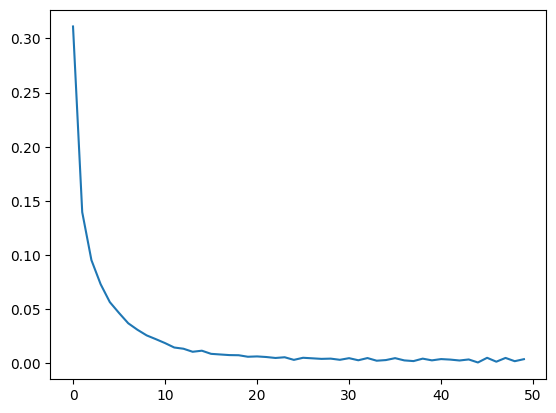

In [6]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'

model = MLP().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

model.train()
loss_history = []

for epoch in range(50):
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.item()
    
    cost = cost / len(train_dataloader)
    loss_history.append(cost)
    print(f'Epoch:{epoch+1:2}  Loss:{cost}')

plt.plot(loss_history)

In [117]:
y = torch.randint(6, (4,))
y_pred = torch.randn(4, 6)

print(y)
print(y_pred)

# Method 1
criterion = nn.CrossEntropyLoss()
loss_1 = criterion(y_pred, y)
print(f'loss_1 : {loss_1}', end='\n\n')


# Method 2
softmax = nn.Softmax(dim=1)
y_pred_softmax = softmax(y_pred)
print(y_pred_softmax)

y_one_hot = torch.nn.functional.one_hot(y, num_classes=6)
print(y_one_hot)

cross_entropy = -1 * y_one_hot * torch.log(y_pred_softmax)
print(torch.sum(cross_entropy) / len(y))

tensor([1, 2, 2, 4])
tensor([[ 0.2332, -0.5665, -0.7956, -0.4474,  0.5677, -1.4139],
        [ 0.3397, -0.9737, -1.6236, -1.1340, -0.3821,  0.9760],
        [-0.1845,  0.7167,  0.1881,  0.7169, -0.5141,  0.5746],
        [-0.8819, -0.1925,  2.1701, -0.0251,  1.6481,  0.6493]])
loss_1 : 2.178593397140503

tensor([[0.2562, 0.1152, 0.0916, 0.1297, 0.3580, 0.0493],
        [0.2492, 0.0670, 0.0350, 0.0571, 0.1211, 0.4707],
        [0.0977, 0.2407, 0.1418, 0.2407, 0.0703, 0.2088],
        [0.0229, 0.0456, 0.4843, 0.0539, 0.2874, 0.1058]])
tensor([[0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]])
tensor(2.1786)


In [30]:
# 모델 save
save_model_path = './model/MLP_MNIST.pt'
torch.save(model.state_dict(), save_model_path)

# model load
load_model = MLP().to(device)
load_model.load_state_dict(torch.load(save_model_path, map_location=device))

<All keys matched successfully>

In [29]:
# model test
correct = 0
wrong = 0

with torch.no_grad():
    model.eval()

    for test_x, test_y in test_dataloader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)

        # accuracy 측정
        y_pred = model(test_x)
        
        for idx in range(len(test_y)):
            if torch.argmax(y_pred, dim=1)[idx] == test_y[idx]:
                correct += 1
            else:
                wrong += 1

    print(f'Correct : {correct}')
    print(f'Wrong   : {wrong}')
    print(f'Accuracy : {round(correct/(correct+wrong) * 100, 2)}%')

Correct : 9745
Wrong   : 239
Accuracy : 97.61%
